In [1]:
__copyright__ = "Reiner Lemoine Institut gGmbH"
__license__   = "GNU Affero General Public License Version 3 (AGPL-3.0)"
__url__       = "https://github.com/openego/eDisGo/blob/master/LICENSE"
__author__    = "gplssm, birgits"

# eDisGo basic example

This example shows you the first steps with eDisGo. Grid expansion costs for an example distribution grid are calculated assuming renewable and conventional power plant capacities as stated in the scenario framework of the German Grid Development Plan 2015 (Netzentwicklungsplan) for the year 2035 (scenario B2). Through this, the data structure used in eDisGo is explained and it is shown how to get distribution grid data, how to use the automatic grid reinforcement methodology to determine grid expansion needs and costs and how to evaluate your results.


### Learn more about eDisGo

* __[eDisGo Source Code](https://github.com/openego/eDisGo)__
* __[eDisGo Documentation](http://edisgo.readthedocs.io/en/dev/)__

### Table of Contents


* [Installation](#installation)
* [Settings](#settings)
* [eDisGo data structure](#network)
* [Future generator scenario](#generator_scenario)
* [Grid reinforcement](#grid_reinforcement)
* [Results evaluation](#evaluation)
* [References](#references)

## Installation <a class="anchor" id="installation"></a>

This notebook requires a working installation of eDisGo as well as `jupyter notebook` to run the example and `contextily` and `geopandas` to view the grid topology on a map. You can install all of these as follows:

```python
pip install eDisGo[examples,geoplot]
```

Checkout the eDisGo documentation on [how to install eDisGo](https://edisgo.readthedocs.io/en/features-refactoring/quickstart.html#installation) for more information.

#### Import packages

In [2]:
import os
import sys
import pandas as pd

from edisgo import EDisGo

/usr/local/anaconda3/envs/edisgo/lib/python3.6/site-packages/sqlalchemy/ext/declarative/base.py:338: SAWarning: Ignoring declarative-like tuple value of attribute segment: possibly a copy-and-paste error with a comma left at the end of the line?
  "left at the end of the line?" % k)
/usr/local/anaconda3/envs/edisgo/lib/python3.6/site-packages/sqlalchemy/ext/declarative/base.py:338: SAWarning: Ignoring declarative-like tuple value of attribute cable: possibly a copy-and-paste error with a comma left at the end of the line?
  "left at the end of the line?" % k)


### Settings <a class="anchor" id="settings"></a>

The class **EDisGo** serves as the top-level API for
setting up your scenario, invocation of data import, power flow analysis, grid reinforcement and flexibility measures. It also provides access to all relevant data. See the [class documentation](http://edisgo.readthedocs.io/en/dev/api/edisgo.grid.html#edisgo.grid.network.EDisGo) for more information.

To set up a scenario to do a worst-case analysis that considers the heavy load flow and reverse power flow cases used in distribution grid planning, you simply have to provide a grid and set the 'worst_case_analysis' parameter, which is both explained in the following two sections. 

#### Distribution grid data

Currently, synthetic grid data generated with the python project
[ding0](https://github.com/openego/ding0)
is the only supported data source for distribution grid data. ding0 provides the grid topology data in the form of csv files, with separate files for buses, lines, loads, generators, etc. You can retrieve ding0 data from
[Zenodo](https://zenodo.org/record/890479)
(make sure you choose latest data) or check out the
[Ding0 documentation](https://dingo.readthedocs.io/en/dev/usage_details.html#ding0-examples)
on how to generate grids yourself. A ding0 example grid can be viewed [here](https://github.com/openego/eDisGo/tree/features/refactoring/tests/ding0_test_network_2). It is possible to provide your own grid data if it is in the same format as the ding0 grid data. 

This example works with any ding0 grid data. If you don't have grid data yet, you can execute the following to download the example grid data mentioned above.

In [3]:
import requests

def download_ding0_example_grid():
    
    # create directories to save ding0 example grid into
    ding0_example_grid_path = os.path.join(
        os.path.expanduser("~"),
        ".edisgo",
        "ding0_test_network")
    os.makedirs(
        ding0_example_grid_path,
        exist_ok=True)

    # download files
    filenames = [
        "buses", "generators", "lines", "loads", "network",
        "switches", "transformers", "transformers_hvmv"]

    for file in filenames:
        req = requests.get(
            "https://raw.githubusercontent.com/openego/eDisGo/features/refactoring/tests/ding0_test_network_2/{}.csv".format(file))
        filename = os.path.join(ding0_example_grid_path, "{}.csv".format(file))
        with open(filename, "wb") as fout:
            fout.write(req.content)

download_ding0_example_grid()

The ding0 grid you want to use in your analysis is specified through the input parameter 'ding0_grid' of the EDisGo class. The following assumes you want to use the ding0 example grid downloaded above. To use a different ding0 grid, just change the path below.

In [4]:
ding0_grid = os.path.join(
    os.path.expanduser("~"),
    ".edisgo",
    "ding0_test_network")

#### Specifying worst-cases

In conventional grid expansion planning worst-cases, the heavy load flow and the reverse power flow, are used to determine grid expansion needs. eDisGo allows you to analyze these cases separately or together. Choose between the following options:

* **’worst-case-feedin’** 
  
  Feed-in and demand for the worst-case scenario "reverse power flow" are generated. Demand is by default set to 15% of maximum demand  for loads connected to the MV grid and 10% for loads connected to the LV grid. Feed-in of all generators is set to the nominal power of the generator, except for PV systems where it is by default set to 85% of the nominal power.

  
* **’worst-case-load’**

  Feed-in and demand for the worst-case scenario "heavy load flow" are generated. Demand of all loads is by default set to maximum demand; feed-in of all generators is set to zero.


* **’worst-case’**
  
  Feed-in and demand for the two worst-case scenarios "reverse power flow" and "heavy load flow" are generated.

Feed-in and demand in the two worst-cases are defined in the [config file 'config_timeseries.cfg'](https://edisgo.readthedocs.io/en/latest/configs.html#config-timeseries) and can be changed by setting different values in the config file. 

Instead of doing a worst-case analysis you can also provide your own timeseries for demand and feed-in and use those in the power flow analysis. EDisGo also offers methods to generate load and feed-in time series. Check out the [EDisGo class documentation](http://edisgo.readthedocs.io/en/dev/api/edisgo.grid.html#edisgo.grid.network.EDisGo) and examples in the [getting started documentation section](https://edisgo.readthedocs.io/en/dev/quickstart.html#a-minimum-working-example) for more information.

In [5]:
worst_case_analysis = 'worst-case'

Now we are ready to initialize the edisgo object.

In [6]:
edisgo = EDisGo(ding0_grid=ding0_grid,
                worst_case_analysis=worst_case_analysis)

Importing PyPSA from older version of PyPSA than current version 0.17.1.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.

INFO:pypsa.io:Imported network ding0_test_network has buses, generators, lines, loads, transformers


### eDisGo data structure <a class="anchor" id="network"></a>

As stated above, the EDisGo class serves as the top-level API and provides access to all relevant data. It also enables plotting of the grid topology. In order to have a look at the MV grid topology, you can use the following plot.

Here, red nodes stand for the substation's secondary side, light blue nodes for distribution substation's primary sides, green nodes for nodes fluctuating generators are connected to, grey nodes for disconnecting points and dark blue nodes show branch tees.
Underlying LV grids are not georeferenced in ding0, wherefore a plotting for LV grids analog to the one shown above is not provided. A different possibility to get a graphical representation of LV grids is shown later in this example. Let's first get into eDisGo's data structure.

Grid data is stored in the [Topology](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.topology.Topology) class.
Time series data can be found in the [TimeSeries](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.timeseries.TimeSeries) class. Results data holding results e.g. from the power flow analysis and grid expansion is stored in the [Results](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.results.Results) class.
Configuration data from the config files (see [default_configs](https://edisgo.readthedocs.io/en/features-refactoring/configs.html#default-configuration-data)) is stored
in the [Config](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.tools.html#edisgo.tools.config.Config) class.
All these can be accessed as follows:

```python
edisgo.topology
edisgo.timeseries
edisgo.results
edisgo.config
```

The grid data in the Topology object is stored in pandas DataFrames.
There are extra data frames for all grid elements (buses, lines, switches, transformers), as well as generators, loads and storage units.
You can access those dataframes as follows:

In [7]:
# Access all buses in MV grid and underlying LV grids
# .head() enables only viewing the first entries of the dataframe
edisgo.topology.buses_df.head()

,v_nom,x,y,mv_grid_id,lv_grid_id,in_building
name,,,,,,
Busbar_mvgd_2761_MV,10.0,11.755702,51.775728,2761,NaN,False
BusBar_mvgd_2761_lvgd_509385_MV,10.0,11.798421,51.756185,2761,NaN,False
BusBar_mvgd_2761_lvgd_509386_MV,10.0,11.793453,51.756824,2761,NaN,False
BusBar_mvgd_2761_lvgd_196762_MV,10.0,11.802969,51.764176,2761,NaN,False
BusBar_mvgd_2761_lvgd_196760_MV,10.0,11.797627,51.761021,2761,NaN,False


In [8]:
# Access all lines in MV grid and underlying LV grids
edisgo.topology.mv_grid.lines_df.head()

,bus0,bus1,length,x,r,s_nom,type_info,kind,num_parallel
name,,,,,,,,,
Branch_Generator_mvgd_2761_wind_onshore_1475347_Generator_mvgd_2761_wind_onshore_1475356,Bus_mvgd_2761_gen_1475347,Bus_mvgd_2761_gen_1475356,0.919241,0.092412,0.056074,10.548189,NA2XS2Y 3x1x500 RM/35,cable,1.0
Branch_Generator_mvgd_2761_wind_onshore_1475347_MVCableDist_mvgd_2761_11,Bus_mvgd_2761_gen_1475347,BranchTee_mvgd_2761_11,0.581396,0.058448,0.035465,10.548189,NA2XS2Y 3x1x500 RM/35,cable,1.0
Branch_Generator_mvgd_2761_wind_onshore_1475347_MVCableDist_mvgd_2761_8,Bus_mvgd_2761_gen_1475347,BranchTee_mvgd_2761_8,1.575013,0.158338,0.096076,10.548189,NA2XS2Y 3x1x500 RM/35,cable,1.0
Branch_Generator_mvgd_2761_wind_onshore_1475348_Generator_mvgd_2761_wind_onshore_1475355,Bus_mvgd_2761_gen_1475348,Bus_mvgd_2761_gen_1475355,0.919243,0.092412,0.056074,10.548189,NA2XS2Y 3x1x500 RM/35,cable,1.0
Branch_Generator_mvgd_2761_wind_onshore_1475348_MVCableDist_mvgd_2761_12,Bus_mvgd_2761_gen_1475348,BranchTee_mvgd_2761_12,0.459617,0.046206,0.028037,10.548189,NA2XS2Y 3x1x500 RM/35,cable,1.0


In [9]:
# Access all generators in MV grid and underlying LV grids
edisgo.topology.generators_df.head()

,bus,control,p_nom,type,subtype,weather_cell_id
name,,,,,,
Generator_mvgd_2761_lvgd_203884_solar_roof_mounted_1593663,Busbar_mvgd_2761_MV,PQ,0.00900,solar,solar_roof_mounted,1133092.0
Generator_mvgd_2761_lvgd_203886_solar_roof_mounted_1564359,Busbar_mvgd_2761_MV,PQ,0.00612,solar,solar_roof_mounted,1133092.0
Generator_mvgd_2761_lvgd_203893_solar_roof_mounted_1604374,Busbar_mvgd_2761_MV,PQ,0.00400,solar,solar_roof_mounted,1133092.0
Generator_mvgd_2761_lvgd_203897_solar_roof_mounted_1567265,Busbar_mvgd_2761_MV,PQ,0.00200,solar,solar_roof_mounted,1133092.0
Generator_mvgd_2761_lvgd_203898_solar_roof_mounted_1572933,Busbar_mvgd_2761_MV,PQ,0.00624,solar,solar_roof_mounted,1133092.0


The grids can also be accessed individually. The MV grid is stored in an [MVGrid](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.grids.MVGrid) object and each LV grid in an
[LVGrid](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.grids.LVGrid) object.
The MV grid topology can be accessed through:

```python
edisgo.topology.mv_grid
```

Its components can be accessed analog to those of the whole grid topology as shown above.

In [10]:
# Access all buses in MV grid
edisgo.topology.mv_grid.buses_df.head()

,v_nom,x,y,mv_grid_id,lv_grid_id,in_building
name,,,,,,
Busbar_mvgd_2761_MV,10.0,11.755702,51.775728,2761,NaN,False
BusBar_mvgd_2761_lvgd_509385_MV,10.0,11.798421,51.756185,2761,NaN,False
BusBar_mvgd_2761_lvgd_509386_MV,10.0,11.793453,51.756824,2761,NaN,False
BusBar_mvgd_2761_lvgd_196762_MV,10.0,11.802969,51.764176,2761,NaN,False
BusBar_mvgd_2761_lvgd_196760_MV,10.0,11.797627,51.761021,2761,NaN,False


In [11]:
# Access all generators in MV grid
edisgo.topology.mv_grid.generators_df.head()

,bus,control,p_nom,type,subtype,weather_cell_id
name,,,,,,
Generator_mvgd_2761_lvgd_203884_solar_roof_mounted_1593663,Busbar_mvgd_2761_MV,PQ,0.00900,solar,solar_roof_mounted,1133092.0
Generator_mvgd_2761_lvgd_203886_solar_roof_mounted_1564359,Busbar_mvgd_2761_MV,PQ,0.00612,solar,solar_roof_mounted,1133092.0
Generator_mvgd_2761_lvgd_203893_solar_roof_mounted_1604374,Busbar_mvgd_2761_MV,PQ,0.00400,solar,solar_roof_mounted,1133092.0
Generator_mvgd_2761_lvgd_203897_solar_roof_mounted_1567265,Busbar_mvgd_2761_MV,PQ,0.00200,solar,solar_roof_mounted,1133092.0
Generator_mvgd_2761_lvgd_203898_solar_roof_mounted_1572933,Busbar_mvgd_2761_MV,PQ,0.00624,solar,solar_roof_mounted,1133092.0


A list of all LV grids can be retrieved through:

In [12]:
# Get list of all underlying LV grids
# (Note that MVGrid.lv_grids returns a generator object that must first be
#  converted to a list in order to view the LVGrid objects)
list(edisgo.topology.mv_grid.lv_grids)

[LVGrid_198682,
 LVGrid_449894,
 LVGrid_509384,
 LVGrid_509385,
 LVGrid_509386,
 LVGrid_198601,
 LVGrid_198602,
 LVGrid_198683,
 LVGrid_196758,
 LVGrid_196759,
 LVGrid_196760,
 LVGrid_196761,
 LVGrid_196762,
 LVGrid_449723,
 LVGrid_198684,
 LVGrid_198685]

Access to a single LV grid's components can be obtained analog to shown above for
the whole topology and the MV grid:

In [13]:
# Get single LV grid
lv_grid = list(edisgo.topology.mv_grid.lv_grids)[0]

In [14]:
# Access all buses in that LV grid
lv_grid.buses_df

,v_nom,x,y,mv_grid_id,lv_grid_id,in_building
name,,,,,,
BusBar_mvgd_2761_lvgd_198682_LV,0.4,11.813709,51.771838,2761,198682.0,False
BranchTee_mvgd_2761_lvgd_198682_1,0.4,NaN,NaN,2761,198682.0,False
BranchTee_mvgd_2761_lvgd_198682_2,0.4,NaN,NaN,2761,198682.0,True
Bus_mvgd_2761_lvgd_198682_loa_1,0.4,NaN,NaN,2761,198682.0,False
BranchTee_mvgd_2761_lvgd_198682_3,0.4,NaN,NaN,2761,198682.0,False
BranchTee_mvgd_2761_lvgd_198682_4,0.4,NaN,NaN,2761,198682.0,True
Bus_mvgd_2761_lvgd_198682_loa_2,0.4,NaN,NaN,2761,198682.0,False


In [15]:
# Access all loads in that LV grid
lv_grid.loads_df

,bus,peak_load,sector,annual_consumption
name,,,,
Load_mvgd_2761_lvgd_198682_1,Bus_mvgd_2761_lvgd_198682_loa_1,0.206535,retail,859.128958
Load_mvgd_2761_lvgd_198682_2,Bus_mvgd_2761_lvgd_198682_loa_2,0.206535,retail,859.128958


A single grid's generators, loads, storage units and switches can also be
retrieved as [Generator](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.components.Generator) object,
[Load](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.components.Load) object, [Storage](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.components.Storage) object, and
[Switch](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.components.Switch) objects, respecitvely:

In [16]:
# Get all switch disconnectors in MV grid as Switch objects
# (Note that objects are returned as a python generator object that must
#  first be converted to a list in order to view the Load objects)
list(edisgo.topology.mv_grid.switch_disconnectors)

[Switch_circuit_breaker_1]

In [17]:
# Have a look at the state (open or closed) of one of the switch disconnectors
switch = list(edisgo.topology.mv_grid.switch_disconnectors)[0]
switch.state

'open'

In [18]:
# Get all loads in LV grid as Load objects
list(lv_grid.loads)

[Load_Load_mvgd_2761_lvgd_198682_1, Load_Load_mvgd_2761_lvgd_198682_2]

In [19]:
# Have a look at the load time series of one of the loads
load = list(lv_grid.loads)[0]
load.active_power_timeseries

1970-01-01 00:00:00    0.020653
1970-01-01 01:00:00    0.206535
Freq: H, Name: Load_mvgd_2761_lvgd_198682_1, dtype: float64

For some applications it is helpful to get a graph representation of the grid,
e.g. to find the path from the station to a generator. The graph representation
of the whole topology or each single grid can be retrieved as follows:

```python

# Get graph representation of whole topology
edisgo.to_graph()

# Get graph representation for MV grid
edisgo.topology.mv_grid.graph

# Get graph representation for LV grid
lv_grid.graph
```

The returned graph is :networkx:`networkx.Graph<network.Graph>`, where lines are represented
by edges in the graph, and buses and transformers are represented by nodes.

In [20]:
edisgo.to_graph()

In case of the LV grids, the graph can be used to get a rudimentary graphical representation:

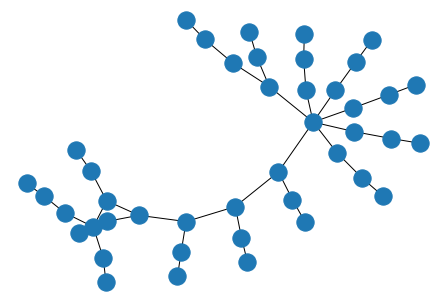

In [21]:
# draw graph of one of the LV grids
import networkx as nx

lv_grid = list(edisgo.topology.mv_grid.lv_grids)[5]
nx.draw(lv_grid.graph)

### Future generator scenario <a class="anchor" id="generator_scenario"></a>

eDisGo was originally developed in the [open_eGo](https://openegoproject.wordpress.com/) research project. In the open_eGo project two future scenarios, the 'NEP 2035' and the 'ego 100' scenario. The 'NEP 2035' scenario closely follows the B2-Scenario 2035 from the German network developement plan (Netzentwicklungsplan NEP) 2015. The share of renewables is 65.8%, electricity demand is assumed to stay the same as in the status quo. The 'ego 100' scenario is based on the e-Highway 2050 scenario and assumes a share of renewables of 100% and again an equal electricity demand as in the status quo.

As mentioned earlier, ding0 grids represent status quo networks with status quo generator capacities (base year is the year 2015). In order to analyse future scenarios future generators have to be imported into the network.

In [22]:
# Get installed capacity in Status Quo
edisgo.topology.generators_df.p_nom.sum()

17.357460000000003

In [23]:
# Import generators
scenario = 'nep2035'
edisgo.import_generators(generator_scenario=scenario)

/usr/local/anaconda3/envs/edisgo/lib/python3.6/site-packages/pandas/core/frame.py:6701: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [24]:
# Get installed capacity in NEP 2035 scenario
edisgo.topology.generators_df.p_nom.sum()

32.245750000000015

Let's have a look at the MV grid topology in the NEP 2035 scenario:

/Users/heikernleong/Documents/localFiles/sa_code/edisgo/eDisGo/edisgo/tools/plots.py:588: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ][edisgo_obj.topology.lines_df.bus1.isin(pypsa_plot.buses.index)].loc[


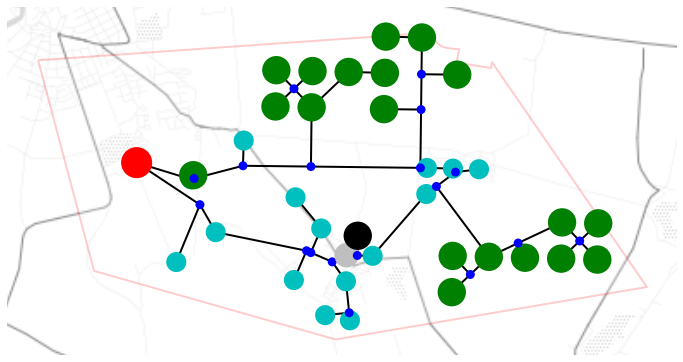

In [25]:
edisgo.plot_mv_grid_topology(technologies=True)

### Grid reinforcement <a class="anchor" id="grid_reinforcement"></a>

Now we can calculate grid expansion costs that arise from the integration of the new generators.

The grid expansion methodology is based on the distribution grid study of dena [[1]](#[1]) and Baden-Wuerttemberg [[2]](#[2]). The order grid expansion measures are conducted is as follows:

* Reinforce transformers and lines due to overloading issues
* Reinforce lines in MV grid due to voltage issues
* Reinforce distribution substations due to voltage issues
* Reinforce lines in LV grid due to voltage issues
* Reinforce transformers and lines due to overloading issues

Reinforcement of transformers and lines due to overloading issues is performed twice, once in the beginning and again after fixing voltage problems, as the changed power flows after reinforcing the grid may lead to new overloading issues. (For further explanation see the [documentation](http://edisgo.readthedocs.io/en/dev/features_in_detail.html#automatic-grid-expansion).)

After each reinforcement step a non-linear power flow analyses is conducted using PyPSA. Let's do a power flow analysis before the reinforcement to see how many over-loading and voltage issues there are.

In [26]:
# Do non-linear power flow analysis with PyPSA
edisgo.analyze()

/usr/local/anaconda3/envs/edisgo/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


ValueError: Following generators have no `p_set` time series                                                                        bus  \
Generator_gas_MVGrid_2761_1609430                    Bus_Generator_1609430   
Generator_solar_MVGrid_2761_1688769                  Bus_Generator_1688769   
Generator_solar_MVGrid_2761_1688770                  Bus_Generator_1688769   
Generator_solar_MVGrid_2761_1688771                  Bus_Generator_1688769   
Generator_wind_MVGrid_2761_2623789                   Bus_Generator_2623789   
Generator_wind_MVGrid_2761_2623790                   Bus_Generator_2623790   
Generator_wind_MVGrid_2761_2623791                   Bus_Generator_2623791   
Generator_solar_MVGrid_2761_1688772                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688773                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_198684_1688774    BranchTee_mvgd_2761_lvgd_198684_6   
Generator_solar_LVGrid_196760_1688775   BranchTee_mvgd_2761_lvgd_196760_26   
Generator_solar_LVGrid_198601_1688776   BranchTee_mvgd_2761_lvgd_198601_18   
Generator_solar_MVGrid_2761_1688777                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688778                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688779                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_196760_1688780   BranchTee_mvgd_2761_lvgd_196760_74   
Generator_solar_MVGrid_2761_1688781                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_196760_1688782   BranchTee_mvgd_2761_lvgd_196760_16   
Generator_solar_LVGrid_198602_1688783   BranchTee_mvgd_2761_lvgd_198602_12   
Generator_solar_LVGrid_196761_1688784   BranchTee_mvgd_2761_lvgd_196761_84   
Generator_solar_LVGrid_198683_1688785   BranchTee_mvgd_2761_lvgd_198683_70   
Generator_solar_MVGrid_2761_1688786                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_198602_1688787   BranchTee_mvgd_2761_lvgd_198602_14   
Generator_solar_LVGrid_196759_1688788  BranchTee_mvgd_2761_lvgd_196759_170   
Generator_solar_LVGrid_196760_1688789   BranchTee_mvgd_2761_lvgd_196760_66   
Generator_solar_MVGrid_2761_1688790                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_198682_1688791    BranchTee_mvgd_2761_lvgd_198682_3   
Generator_solar_MVGrid_2761_1688792                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_196760_1688793   BranchTee_mvgd_2761_lvgd_196760_18   
Generator_solar_MVGrid_2761_1688794                    Busbar_mvgd_2761_MV   
...                                                                    ...   
Generator_solar_MVGrid_2761_1688819                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688820                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688821                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688822                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688823                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688824                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_196759_1688825  BranchTee_mvgd_2761_lvgd_196759_148   
Generator_solar_LVGrid_196759_1688826   BranchTee_mvgd_2761_lvgd_196759_26   
Generator_solar_MVGrid_2761_1688827                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688828                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688829                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688830                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_196760_1688831   BranchTee_mvgd_2761_lvgd_196760_14   
Generator_solar_LVGrid_198602_1688832   BranchTee_mvgd_2761_lvgd_198602_24   
Generator_solar_MVGrid_2761_1688833                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688834                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_196759_1688835   BranchTee_mvgd_2761_lvgd_196759_54   
Generator_solar_MVGrid_2761_1688836                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688837                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688838                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688839                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688840                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688841                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_198684_1688842   BranchTee_mvgd_2761_lvgd_198684_42   
Generator_solar_MVGrid_2761_1688843                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_509384_1688844    BranchTee_mvgd_2761_lvgd_509384_1   
Generator_solar_MVGrid_2761_1688845                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688846                    Busbar_mvgd_2761_MV   
Generator_solar_MVGrid_2761_1688847                    Busbar_mvgd_2761_MV   
Generator_solar_LVGrid_509386_1688848   BranchTee_mvgd_2761_lvgd_509386_32   

                                      control type    p_nom  p_nom_extendable  \
Generator_gas_MVGrid_2761_1609430          PQ       1.34229             False   
Generator_solar_MVGrid_2761_1688769        PQ       3.93500             False   
Generator_solar_MVGrid_2761_1688770        PQ       0.32200             False   
Generator_solar_MVGrid_2761_1688771        PQ       3.97800             False   
Generator_wind_MVGrid_2761_2623789         PQ       1.48800             False   
Generator_wind_MVGrid_2761_2623790         PQ       1.48800             False   
Generator_wind_MVGrid_2761_2623791         PQ       1.48800             False   
Generator_solar_MVGrid_2761_1688772        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688773        PQ       0.01100             False   
Generator_solar_LVGrid_198684_1688774      PQ       0.01100             False   
Generator_solar_LVGrid_196760_1688775      PQ       0.01100             False   
Generator_solar_LVGrid_198601_1688776      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688777        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688778        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688779        PQ       0.01100             False   
Generator_solar_LVGrid_196760_1688780      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688781        PQ       0.01100             False   
Generator_solar_LVGrid_196760_1688782      PQ       0.01100             False   
Generator_solar_LVGrid_198602_1688783      PQ       0.01100             False   
Generator_solar_LVGrid_196761_1688784      PQ       0.01100             False   
Generator_solar_LVGrid_198683_1688785      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688786        PQ       0.01100             False   
Generator_solar_LVGrid_198602_1688787      PQ       0.01100             False   
Generator_solar_LVGrid_196759_1688788      PQ       0.01100             False   
Generator_solar_LVGrid_196760_1688789      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688790        PQ       0.01100             False   
Generator_solar_LVGrid_198682_1688791      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688792        PQ       0.01100             False   
Generator_solar_LVGrid_196760_1688793      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688794        PQ       0.01100             False   
...                                       ...  ...      ...               ...   
Generator_solar_MVGrid_2761_1688819        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688820        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688821        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688822        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688823        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688824        PQ       0.01100             False   
Generator_solar_LVGrid_196759_1688825      PQ       0.01100             False   
Generator_solar_LVGrid_196759_1688826      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688827        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688828        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688829        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688830        PQ       0.01100             False   
Generator_solar_LVGrid_196760_1688831      PQ       0.01100             False   
Generator_solar_LVGrid_198602_1688832      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688833        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688834        PQ       0.01100             False   
Generator_solar_LVGrid_196759_1688835      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688836        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688837        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688838        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688839        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688840        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688841        PQ       0.01100             False   
Generator_solar_LVGrid_198684_1688842      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688843        PQ       0.01100             False   
Generator_solar_LVGrid_509384_1688844      PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688845        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688846        PQ       0.01100             False   
Generator_solar_MVGrid_2761_1688847        PQ       0.01100             False   
Generator_solar_LVGrid_509386_1688848      PQ       0.01100             False   

                                       p_nom_min  p_nom_max  p_min_pu  \
Generator_gas_MVGrid_2761_1609430            0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688769          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688770          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688771          0.0        inf       0.0   
Generator_wind_MVGrid_2761_2623789           0.0        inf       0.0   
Generator_wind_MVGrid_2761_2623790           0.0        inf       0.0   
Generator_wind_MVGrid_2761_2623791           0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688772          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688773          0.0        inf       0.0   
Generator_solar_LVGrid_198684_1688774        0.0        inf       0.0   
Generator_solar_LVGrid_196760_1688775        0.0        inf       0.0   
Generator_solar_LVGrid_198601_1688776        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688777          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688778          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688779          0.0        inf       0.0   
Generator_solar_LVGrid_196760_1688780        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688781          0.0        inf       0.0   
Generator_solar_LVGrid_196760_1688782        0.0        inf       0.0   
Generator_solar_LVGrid_198602_1688783        0.0        inf       0.0   
Generator_solar_LVGrid_196761_1688784        0.0        inf       0.0   
Generator_solar_LVGrid_198683_1688785        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688786          0.0        inf       0.0   
Generator_solar_LVGrid_198602_1688787        0.0        inf       0.0   
Generator_solar_LVGrid_196759_1688788        0.0        inf       0.0   
Generator_solar_LVGrid_196760_1688789        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688790          0.0        inf       0.0   
Generator_solar_LVGrid_198682_1688791        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688792          0.0        inf       0.0   
Generator_solar_LVGrid_196760_1688793        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688794          0.0        inf       0.0   
...                                          ...        ...       ...   
Generator_solar_MVGrid_2761_1688819          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688820          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688821          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688822          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688823          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688824          0.0        inf       0.0   
Generator_solar_LVGrid_196759_1688825        0.0        inf       0.0   
Generator_solar_LVGrid_196759_1688826        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688827          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688828          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688829          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688830          0.0        inf       0.0   
Generator_solar_LVGrid_196760_1688831        0.0        inf       0.0   
Generator_solar_LVGrid_198602_1688832        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688833          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688834          0.0        inf       0.0   
Generator_solar_LVGrid_196759_1688835        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688836          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688837          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688838          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688839          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688840          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688841          0.0        inf       0.0   
Generator_solar_LVGrid_198684_1688842        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688843          0.0        inf       0.0   
Generator_solar_LVGrid_509384_1688844        0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688845          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688846          0.0        inf       0.0   
Generator_solar_MVGrid_2761_1688847          0.0        inf       0.0   
Generator_solar_LVGrid_509386_1688848        0.0        inf       0.0   

                                       p_max_pu  p_set  ...  shut_down_cost  \
Generator_gas_MVGrid_2761_1609430           1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688769         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688770         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688771         1.0    0.0  ...             0.0   
Generator_wind_MVGrid_2761_2623789          1.0    0.0  ...             0.0   
Generator_wind_MVGrid_2761_2623790          1.0    0.0  ...             0.0   
Generator_wind_MVGrid_2761_2623791          1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688772         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688773         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_198684_1688774       1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196760_1688775       1.0    0.0  ...             0.0   
Generator_solar_LVGrid_198601_1688776       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688777         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688778         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688779         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196760_1688780       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688781         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196760_1688782       1.0    0.0  ...             0.0   
Generator_solar_LVGrid_198602_1688783       1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196761_1688784       1.0    0.0  ...             0.0   
Generator_solar_LVGrid_198683_1688785       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688786         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_198602_1688787       1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196759_1688788       1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196760_1688789       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688790         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_198682_1688791       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688792         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196760_1688793       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688794         1.0    0.0  ...             0.0   
...                                         ...    ...  ...             ...   
Generator_solar_MVGrid_2761_1688819         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688820         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688821         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688822         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688823         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688824         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196759_1688825       1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196759_1688826       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688827         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688828         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688829         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688830         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196760_1688831       1.0    0.0  ...             0.0   
Generator_solar_LVGrid_198602_1688832       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688833         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688834         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_196759_1688835       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688836         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688837         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688838         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688839         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688840         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688841         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_198684_1688842       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688843         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_509384_1688844       1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688845         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688846         1.0    0.0  ...             0.0   
Generator_solar_MVGrid_2761_1688847         1.0    0.0  ...             0.0   
Generator_solar_LVGrid_509386_1688848       1.0    0.0  ...             0.0   

                                       min_up_time min_down_time  \
Generator_gas_MVGrid_2761_1609430                0             0   
Generator_solar_MVGrid_2761_1688769              0             0   
Generator_solar_MVGrid_2761_1688770              0             0   
Generator_solar_MVGrid_2761_1688771              0             0   
Generator_wind_MVGrid_2761_2623789               0             0   
Generator_wind_MVGrid_2761_2623790               0             0   
Generator_wind_MVGrid_2761_2623791               0             0   
Generator_solar_MVGrid_2761_1688772              0             0   
Generator_solar_MVGrid_2761_1688773              0             0   
Generator_solar_LVGrid_198684_1688774            0             0   
Generator_solar_LVGrid_196760_1688775            0             0   
Generator_solar_LVGrid_198601_1688776            0             0   
Generator_solar_MVGrid_2761_1688777              0             0   
Generator_solar_MVGrid_2761_1688778              0             0   
Generator_solar_MVGrid_2761_1688779              0             0   
Generator_solar_LVGrid_196760_1688780            0             0   
Generator_solar_MVGrid_2761_1688781              0             0   
Generator_solar_LVGrid_196760_1688782            0             0   
Generator_solar_LVGrid_198602_1688783            0             0   
Generator_solar_LVGrid_196761_1688784            0             0   
Generator_solar_LVGrid_198683_1688785            0             0   
Generator_solar_MVGrid_2761_1688786              0             0   
Generator_solar_LVGrid_198602_1688787            0             0   
Generator_solar_LVGrid_196759_1688788            0             0   
Generator_solar_LVGrid_196760_1688789            0             0   
Generator_solar_MVGrid_2761_1688790              0             0   
Generator_solar_LVGrid_198682_1688791            0             0   
Generator_solar_MVGrid_2761_1688792              0             0   
Generator_solar_LVGrid_196760_1688793            0             0   
Generator_solar_MVGrid_2761_1688794              0             0   
...                                            ...           ...   
Generator_solar_MVGrid_2761_1688819              0             0   
Generator_solar_MVGrid_2761_1688820              0             0   
Generator_solar_MVGrid_2761_1688821              0             0   
Generator_solar_MVGrid_2761_1688822              0             0   
Generator_solar_MVGrid_2761_1688823              0             0   
Generator_solar_MVGrid_2761_1688824              0             0   
Generator_solar_LVGrid_196759_1688825            0             0   
Generator_solar_LVGrid_196759_1688826            0             0   
Generator_solar_MVGrid_2761_1688827              0             0   
Generator_solar_MVGrid_2761_1688828              0             0   
Generator_solar_MVGrid_2761_1688829              0             0   
Generator_solar_MVGrid_2761_1688830              0             0   
Generator_solar_LVGrid_196760_1688831            0             0   
Generator_solar_LVGrid_198602_1688832            0             0   
Generator_solar_MVGrid_2761_1688833              0             0   
Generator_solar_MVGrid_2761_1688834              0             0   
Generator_solar_LVGrid_196759_1688835            0             0   
Generator_solar_MVGrid_2761_1688836              0             0   
Generator_solar_MVGrid_2761_1688837              0             0   
Generator_solar_MVGrid_2761_1688838              0             0   
Generator_solar_MVGrid_2761_1688839              0             0   
Generator_solar_MVGrid_2761_1688840              0             0   
Generator_solar_MVGrid_2761_1688841              0             0   
Generator_solar_LVGrid_198684_1688842            0             0   
Generator_solar_MVGrid_2761_1688843              0             0   
Generator_solar_LVGrid_509384_1688844            0             0   
Generator_solar_MVGrid_2761_1688845              0             0   
Generator_solar_MVGrid_2761_1688846              0             0   
Generator_solar_MVGrid_2761_1688847              0             0   
Generator_solar_LVGrid_509386_1688848            0             0   

                                       up_time_before  down_time_before  \
Generator_gas_MVGrid_2761_1609430                   1                 0   
Generator_solar_MVGrid_2761_1688769                 1                 0   
Generator_solar_MVGrid_2761_1688770                 1                 0   
Generator_solar_MVGrid_2761_1688771                 1                 0   
Generator_wind_MVGrid_2761_2623789                  1                 0   
Generator_wind_MVGrid_2761_2623790                  1                 0   
Generator_wind_MVGrid_2761_2623791                  1                 0   
Generator_solar_MVGrid_2761_1688772                 1                 0   
Generator_solar_MVGrid_2761_1688773                 1                 0   
Generator_solar_LVGrid_198684_1688774               1                 0   
Generator_solar_LVGrid_196760_1688775               1                 0   
Generator_solar_LVGrid_198601_1688776               1                 0   
Generator_solar_MVGrid_2761_1688777                 1                 0   
Generator_solar_MVGrid_2761_1688778                 1                 0   
Generator_solar_MVGrid_2761_1688779                 1                 0   
Generator_solar_LVGrid_196760_1688780               1                 0   
Generator_solar_MVGrid_2761_1688781                 1                 0   
Generator_solar_LVGrid_196760_1688782               1                 0   
Generator_solar_LVGrid_198602_1688783               1                 0   
Generator_solar_LVGrid_196761_1688784               1                 0   
Generator_solar_LVGrid_198683_1688785               1                 0   
Generator_solar_MVGrid_2761_1688786                 1                 0   
Generator_solar_LVGrid_198602_1688787               1                 0   
Generator_solar_LVGrid_196759_1688788               1                 0   
Generator_solar_LVGrid_196760_1688789               1                 0   
Generator_solar_MVGrid_2761_1688790                 1                 0   
Generator_solar_LVGrid_198682_1688791               1                 0   
Generator_solar_MVGrid_2761_1688792                 1                 0   
Generator_solar_LVGrid_196760_1688793               1                 0   
Generator_solar_MVGrid_2761_1688794                 1                 0   
...                                               ...               ...   
Generator_solar_MVGrid_2761_1688819                 1                 0   
Generator_solar_MVGrid_2761_1688820                 1                 0   
Generator_solar_MVGrid_2761_1688821                 1                 0   
Generator_solar_MVGrid_2761_1688822                 1                 0   
Generator_solar_MVGrid_2761_1688823                 1                 0   
Generator_solar_MVGrid_2761_1688824                 1                 0   
Generator_solar_LVGrid_196759_1688825               1                 0   
Generator_solar_LVGrid_196759_1688826               1                 0   
Generator_solar_MVGrid_2761_1688827                 1                 0   
Generator_solar_MVGrid_2761_1688828                 1                 0   
Generator_solar_MVGrid_2761_1688829                 1                 0   
Generator_solar_MVGrid_2761_1688830                 1                 0   
Generator_solar_LVGrid_196760_1688831               1                 0   
Generator_solar_LVGrid_198602_1688832               1                 0   
Generator_solar_MVGrid_2761_1688833                 1                 0   
Generator_solar_MVGrid_2761_1688834                 1                 0   
Generator_solar_LVGrid_196759_1688835               1                 0   
Generator_solar_MVGrid_2761_1688836                 1                 0   
Generator_solar_MVGrid_2761_1688837                 1                 0   
Generator_solar_MVGrid_2761_1688838                 1                 0   
Generator_solar_MVGrid_2761_1688839                 1                 0   
Generator_solar_MVGrid_2761_1688840                 1                 0   
Generator_solar_MVGrid_2761_1688841                 1                 0   
Generator_solar_LVGrid_198684_1688842               1                 0   
Generator_solar_MVGrid_2761_1688843                 1                 0   
Generator_solar_LVGrid_509384_1688844               1                 0   
Generator_solar_MVGrid_2761_1688845                 1                 0   
Generator_solar_MVGrid_2761_1688846                 1                 0   
Generator_solar_MVGrid_2761_1688847                 1                 0   
Generator_solar_LVGrid_509386_1688848               1                 0   

                                       ramp_limit_up  ramp_limit_down  \
Generator_gas_MVGrid_2761_1609430                NaN              NaN   
Generator_solar_MVGrid_2761_1688769              NaN              NaN   
Generator_solar_MVGrid_2761_1688770              NaN              NaN   
Generator_solar_MVGrid_2761_1688771              NaN              NaN   
Generator_wind_MVGrid_2761_2623789               NaN              NaN   
Generator_wind_MVGrid_2761_2623790               NaN              NaN   
Generator_wind_MVGrid_2761_2623791               NaN              NaN   
Generator_solar_MVGrid_2761_1688772              NaN              NaN   
Generator_solar_MVGrid_2761_1688773              NaN              NaN   
Generator_solar_LVGrid_198684_1688774            NaN              NaN   
Generator_solar_LVGrid_196760_1688775            NaN              NaN   
Generator_solar_LVGrid_198601_1688776            NaN              NaN   
Generator_solar_MVGrid_2761_1688777              NaN              NaN   
Generator_solar_MVGrid_2761_1688778              NaN              NaN   
Generator_solar_MVGrid_2761_1688779              NaN              NaN   
Generator_solar_LVGrid_196760_1688780            NaN              NaN   
Generator_solar_MVGrid_2761_1688781              NaN              NaN   
Generator_solar_LVGrid_196760_1688782            NaN              NaN   
Generator_solar_LVGrid_198602_1688783            NaN              NaN   
Generator_solar_LVGrid_196761_1688784            NaN              NaN   
Generator_solar_LVGrid_198683_1688785            NaN              NaN   
Generator_solar_MVGrid_2761_1688786              NaN              NaN   
Generator_solar_LVGrid_198602_1688787            NaN              NaN   
Generator_solar_LVGrid_196759_1688788            NaN              NaN   
Generator_solar_LVGrid_196760_1688789            NaN              NaN   
Generator_solar_MVGrid_2761_1688790              NaN              NaN   
Generator_solar_LVGrid_198682_1688791            NaN              NaN   
Generator_solar_MVGrid_2761_1688792              NaN              NaN   
Generator_solar_LVGrid_196760_1688793            NaN              NaN   
Generator_solar_MVGrid_2761_1688794              NaN              NaN   
...                                              ...              ...   
Generator_solar_MVGrid_2761_1688819              NaN              NaN   
Generator_solar_MVGrid_2761_1688820              NaN              NaN   
Generator_solar_MVGrid_2761_1688821              NaN              NaN   
Generator_solar_MVGrid_2761_1688822              NaN              NaN   
Generator_solar_MVGrid_2761_1688823              NaN              NaN   
Generator_solar_MVGrid_2761_1688824              NaN              NaN   
Generator_solar_LVGrid_196759_1688825            NaN              NaN   
Generator_solar_LVGrid_196759_1688826            NaN              NaN   
Generator_solar_MVGrid_2761_1688827              NaN              NaN   
Generator_solar_MVGrid_2761_1688828              NaN              NaN   
Generator_solar_MVGrid_2761_1688829              NaN              NaN   
Generator_solar_MVGrid_2761_1688830              NaN              NaN   
Generator_solar_LVGrid_196760_1688831            NaN              NaN   
Generator_solar_LVGrid_198602_1688832            NaN              NaN   
Generator_solar_MVGrid_2761_1688833              NaN              NaN   
Generator_solar_MVGrid_2761_1688834              NaN              NaN   
Generator_solar_LVGrid_196759_1688835            NaN              NaN   
Generator_solar_MVGrid_2761_1688836              NaN              NaN   
Generator_solar_MVGrid_2761_1688837              NaN              NaN   
Generator_solar_MVGrid_2761_1688838              NaN              NaN   
Generator_solar_MVGrid_2761_1688839              NaN              NaN   
Generator_solar_MVGrid_2761_1688840              NaN              NaN   
Generator_solar_MVGrid_2761_1688841              NaN              NaN   
Generator_solar_LVGrid_198684_1688842            NaN              NaN   
Generator_solar_MVGrid_2761_1688843              NaN              NaN   
Generator_solar_LVGrid_509384_1688844            NaN              NaN   
Generator_solar_MVGrid_2761_1688845              NaN              NaN   
Generator_solar_MVGrid_2761_1688846              NaN              NaN   
Generator_solar_MVGrid_2761_1688847              NaN              NaN   
Generator_solar_LVGrid_509386_1688848            NaN              NaN   

                                       ramp_limit_start_up  \
Generator_gas_MVGrid_2761_1609430                      1.0   
Generator_solar_MVGrid_2761_1688769                    1.0   
Generator_solar_MVGrid_2761_1688770                    1.0   
Generator_solar_MVGrid_2761_1688771                    1.0   
Generator_wind_MVGrid_2761_2623789                     1.0   
Generator_wind_MVGrid_2761_2623790                     1.0   
Generator_wind_MVGrid_2761_2623791                     1.0   
Generator_solar_MVGrid_2761_1688772                    1.0   
Generator_solar_MVGrid_2761_1688773                    1.0   
Generator_solar_LVGrid_198684_1688774                  1.0   
Generator_solar_LVGrid_196760_1688775                  1.0   
Generator_solar_LVGrid_198601_1688776                  1.0   
Generator_solar_MVGrid_2761_1688777                    1.0   
Generator_solar_MVGrid_2761_1688778                    1.0   
Generator_solar_MVGrid_2761_1688779                    1.0   
Generator_solar_LVGrid_196760_1688780                  1.0   
Generator_solar_MVGrid_2761_1688781                    1.0   
Generator_solar_LVGrid_196760_1688782                  1.0   
Generator_solar_LVGrid_198602_1688783                  1.0   
Generator_solar_LVGrid_196761_1688784                  1.0   
Generator_solar_LVGrid_198683_1688785                  1.0   
Generator_solar_MVGrid_2761_1688786                    1.0   
Generator_solar_LVGrid_198602_1688787                  1.0   
Generator_solar_LVGrid_196759_1688788                  1.0   
Generator_solar_LVGrid_196760_1688789                  1.0   
Generator_solar_MVGrid_2761_1688790                    1.0   
Generator_solar_LVGrid_198682_1688791                  1.0   
Generator_solar_MVGrid_2761_1688792                    1.0   
Generator_solar_LVGrid_196760_1688793                  1.0   
Generator_solar_MVGrid_2761_1688794                    1.0   
...                                                    ...   
Generator_solar_MVGrid_2761_1688819                    1.0   
Generator_solar_MVGrid_2761_1688820                    1.0   
Generator_solar_MVGrid_2761_1688821                    1.0   
Generator_solar_MVGrid_2761_1688822                    1.0   
Generator_solar_MVGrid_2761_1688823                    1.0   
Generator_solar_MVGrid_2761_1688824                    1.0   
Generator_solar_LVGrid_196759_1688825                  1.0   
Generator_solar_LVGrid_196759_1688826                  1.0   
Generator_solar_MVGrid_2761_1688827                    1.0   
Generator_solar_MVGrid_2761_1688828                    1.0   
Generator_solar_MVGrid_2761_1688829                    1.0   
Generator_solar_MVGrid_2761_1688830                    1.0   
Generator_solar_LVGrid_196760_1688831                  1.0   
Generator_solar_LVGrid_198602_1688832                  1.0   
Generator_solar_MVGrid_2761_1688833                    1.0   
Generator_solar_MVGrid_2761_1688834                    1.0   
Generator_solar_LVGrid_196759_1688835                  1.0   
Generator_solar_MVGrid_2761_1688836                    1.0   
Generator_solar_MVGrid_2761_1688837                    1.0   
Generator_solar_MVGrid_2761_1688838                    1.0   
Generator_solar_MVGrid_2761_1688839                    1.0   
Generator_solar_MVGrid_2761_1688840                    1.0   
Generator_solar_MVGrid_2761_1688841                    1.0   
Generator_solar_LVGrid_198684_1688842                  1.0   
Generator_solar_MVGrid_2761_1688843                    1.0   
Generator_solar_LVGrid_509384_1688844                  1.0   
Generator_solar_MVGrid_2761_1688845                    1.0   
Generator_solar_MVGrid_2761_1688846                    1.0   
Generator_solar_MVGrid_2761_1688847                    1.0   
Generator_solar_LVGrid_509386_1688848                  1.0   

                                       ramp_limit_shut_down  p_nom_opt  
Generator_gas_MVGrid_2761_1609430                       1.0        0.0  
Generator_solar_MVGrid_2761_1688769                     1.0        0.0  
Generator_solar_MVGrid_2761_1688770                     1.0        0.0  
Generator_solar_MVGrid_2761_1688771                     1.0        0.0  
Generator_wind_MVGrid_2761_2623789                      1.0        0.0  
Generator_wind_MVGrid_2761_2623790                      1.0        0.0  
Generator_wind_MVGrid_2761_2623791                      1.0        0.0  
Generator_solar_MVGrid_2761_1688772                     1.0        0.0  
Generator_solar_MVGrid_2761_1688773                     1.0        0.0  
Generator_solar_LVGrid_198684_1688774                   1.0        0.0  
Generator_solar_LVGrid_196760_1688775                   1.0        0.0  
Generator_solar_LVGrid_198601_1688776                   1.0        0.0  
Generator_solar_MVGrid_2761_1688777                     1.0        0.0  
Generator_solar_MVGrid_2761_1688778                     1.0        0.0  
Generator_solar_MVGrid_2761_1688779                     1.0        0.0  
Generator_solar_LVGrid_196760_1688780                   1.0        0.0  
Generator_solar_MVGrid_2761_1688781                     1.0        0.0  
Generator_solar_LVGrid_196760_1688782                   1.0        0.0  
Generator_solar_LVGrid_198602_1688783                   1.0        0.0  
Generator_solar_LVGrid_196761_1688784                   1.0        0.0  
Generator_solar_LVGrid_198683_1688785                   1.0        0.0  
Generator_solar_MVGrid_2761_1688786                     1.0        0.0  
Generator_solar_LVGrid_198602_1688787                   1.0        0.0  
Generator_solar_LVGrid_196759_1688788                   1.0        0.0  
Generator_solar_LVGrid_196760_1688789                   1.0        0.0  
Generator_solar_MVGrid_2761_1688790                     1.0        0.0  
Generator_solar_LVGrid_198682_1688791                   1.0        0.0  
Generator_solar_MVGrid_2761_1688792                     1.0        0.0  
Generator_solar_LVGrid_196760_1688793                   1.0        0.0  
Generator_solar_MVGrid_2761_1688794                     1.0        0.0  
...                                                     ...        ...  
Generator_solar_MVGrid_2761_1688819                     1.0        0.0  
Generator_solar_MVGrid_2761_1688820                     1.0        0.0  
Generator_solar_MVGrid_2761_1688821                     1.0        0.0  
Generator_solar_MVGrid_2761_1688822                     1.0        0.0  
Generator_solar_MVGrid_2761_1688823                     1.0        0.0  
Generator_solar_MVGrid_2761_1688824                     1.0        0.0  
Generator_solar_LVGrid_196759_1688825                   1.0        0.0  
Generator_solar_LVGrid_196759_1688826                   1.0        0.0  
Generator_solar_MVGrid_2761_1688827                     1.0        0.0  
Generator_solar_MVGrid_2761_1688828                     1.0        0.0  
Generator_solar_MVGrid_2761_1688829                     1.0        0.0  
Generator_solar_MVGrid_2761_1688830                     1.0        0.0  
Generator_solar_LVGrid_196760_1688831                   1.0        0.0  
Generator_solar_LVGrid_198602_1688832                   1.0        0.0  
Generator_solar_MVGrid_2761_1688833                     1.0        0.0  
Generator_solar_MVGrid_2761_1688834                     1.0        0.0  
Generator_solar_LVGrid_196759_1688835                   1.0        0.0  
Generator_solar_MVGrid_2761_1688836                     1.0        0.0  
Generator_solar_MVGrid_2761_1688837                     1.0        0.0  
Generator_solar_MVGrid_2761_1688838                     1.0        0.0  
Generator_solar_MVGrid_2761_1688839                     1.0        0.0  
Generator_solar_MVGrid_2761_1688840                     1.0        0.0  
Generator_solar_MVGrid_2761_1688841                     1.0        0.0  
Generator_solar_LVGrid_198684_1688842                   1.0        0.0  
Generator_solar_MVGrid_2761_1688843                     1.0        0.0  
Generator_solar_LVGrid_509384_1688844                   1.0        0.0  
Generator_solar_MVGrid_2761_1688845                     1.0        0.0  
Generator_solar_MVGrid_2761_1688846                     1.0        0.0  
Generator_solar_MVGrid_2761_1688847                     1.0        0.0  
Generator_solar_LVGrid_509386_1688848                   1.0        0.0  

[84 rows x 28 columns]

In [ ]:
# feed-in case
edisgo.plot_mv_line_loading(
    node_color='voltage_deviation',
    timestep=edisgo.timeseries.timeindex[0])

In [ ]:
# load case
edisgo.plot_mv_line_loading(
    node_color='voltage_deviation',
    timestep=edisgo.timeseries.timeindex[1])

Let's check voltages and line loadings before the reinforcement.

In [ ]:
edisgo.histogram_voltage(binwidth=0.005)

In [ ]:
edisgo.histogram_relative_line_load(binwidth=0.2)

Reinforcement is invoked doing the following:

In [ ]:
# Do grid reinforcement
edisgo.reinforce()

Let's check voltages and line loadings again:

In [ ]:
# load and feed-in case
edisgo.plot_mv_line_loading(
    node_color='voltage_deviation')

In [ ]:
edisgo.histogram_voltage(binwidth=0.005)

In [ ]:
edisgo.histogram_relative_line_load(binwidth=0.2)

### Evaluate results <a class="anchor" id="evaluation"></a>

Results such as voltages at nodes and line loading from the power flow analysis as well as
grid expansion costs are provided through the [Results](https://edisgo.readthedocs.io/en/features-refactoring/api/edisgo.network.html#edisgo.network.results.Results) class. Above it was already shown how to access 
the results:

```python
edisgo.results
```

Get voltages at nodes through `v_res` attribute and line loading through `s_res` or `i_res` attribute.
The `equipment_changes` attribute holds details about measures performed during grid expansion. Associated costs can be obtained through the `grid_expansion_costs` attribute.

In [ ]:
# Get voltages at nodes from last power flow analysis
edisgo.results.v_res

In [ ]:
# View reinforced equipment
edisgo.results.equipment_changes.head()

In [ ]:
# Get costs in kEUR for reinforcement per equipment
costs = edisgo.results.grid_expansion_costs
costs.head()

In [ ]:
# Group costs by voltage level
costs_grouped_nep = costs.groupby(['voltage_level']).sum()
costs_grouped_nep.loc[:, ['total_costs']]

An overview of the assumptions used to calculate grid expansion costs can be found in the [documentation]( http://edisgo.readthedocs.io/en/dev/features_in_detail.html#grid-expansion-costs).

You can also view grid expansion costs for equipment in the MV using the following plot:

In [ ]:
edisgo.plot_mv_grid_expansion_costs()

Results can be saved to csv files with:

```python
edisgo.results.save('path/to/results/directory/')
```

Now let's compare the grid expansion costs for the 'NEP 2035' scenario with grid expansion costs for the 'ego 100' scenario. Therefore, we first have to setup the new scenario and calculate grid expansion costs.

In [ ]:
# initialize new EDisGo object with 'ego 100' scenario
edisgo_ego100 = EDisGo(ding0_grid=ding0_grid,
                       worst_case_analysis=worst_case_analysis,
                       generator_scenario='ego100')
# conduct grid reinforcement
edisgo_ego100.reinforce()

In [ ]:
# get grouped costs
costs_grouped_ego100 = edisgo_ego100.results.grid_expansion_costs.groupby(['voltage_level']).sum()
costs_grouped_ego100.loc[:, ['total_costs']]

In [ ]:
# compare expansion costs for both scenarios in a plot

import matplotlib.pyplot as plt

# set up dataframe to plot
costs_df = costs_grouped_nep.loc[:, ['total_costs']].join(costs_grouped_ego100.loc[:, ['total_costs']], rsuffix='_ego100', lsuffix='_nep2035').rename(
    columns={'total_costs_ego100': 'ego100',
             'total_costs_nep2035': 'NEP2035'}).T
# plot
costs_df.plot(kind='bar', stacked=True)
plt.xticks(rotation=0)
plt.ylabel('Grid reinforcement costs in k€');

## References <a class="anchor" id="references"></a>

<a class="anchor" id="[1]"></a> [1] A.C. Agricola et al.: dena-Verteilnetzstudie: Ausbau- und Innovationsbedarf der Stromverteilnetze in Deutschland bis 2030. 2012.

<a class="anchor" id="[2]"></a> [2] C. Rehtanz et al.: Verteilnetzstudie für das Land Baden-Württemberg, ef.Ruhr GmbH, 2017.